In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 複製到 Colab 工作目錄
!cp /content/drive/MyDrive/dataset_all.zip ./

# 解壓縮
!unzip -q dataset_all.zip -d ./

# 檢查解壓結果
!ls dataset_all


test  train  val


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



# setup

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 224 * 224 * 3
num_classes = 7
batch_size = 4
num_epoch = 10

# dataset

In [35]:
class MultiLabelChiikawaDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.image_names = []
        self.transform = transform

        for fname in sorted(os.listdir(label_dir)):
            if fname.endswith(".txt"):
                image_name = fname.replace(".txt", ".jpg")
                image_path = os.path.join(image_dir, image_name)
                if not os.path.exists(image_path):
                    continue

                # 產生 multi-label one-hot 向量
                label_vector = torch.zeros(num_classes)
                with open(os.path.join(label_dir, fname), "r") as f:
                    for line in f:
                        cls_id = int(line.strip().split()[0])
                        label_vector[cls_id] = 1.0

                self.image_paths.append(image_path)
                self.labels.append(label_vector)
                self.image_names.append(image_name)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        image_name = self.image_names[idx]  # <== 新增
        return image, label, image_name

# 資料轉換

In [33]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)),
])

In [36]:
train_dataset = MultiLabelChiikawaDataset("dataset_all/train/images", "dataset_all/train/labels", transform)
val_dataset = MultiLabelChiikawaDataset("dataset_all/val/images", "dataset_all/val/labels", transform)
test_dataset = MultiLabelChiikawaDataset("dataset_all/test/images", "dataset_all/test/labels", transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# MLP model

In [8]:
class myMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),

            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),


            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.mlp(x)

# Loss

In [9]:
criterion = nn.BCEWithLogitsLoss()

# 初始化模型、loss、optimizer

In [10]:
model = myMLP(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)


# train

In [11]:
for epoch in range(num_epoch):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f}")



Epoch 1 | Loss: 0.5701
Epoch 2 | Loss: 0.4319
Epoch 3 | Loss: 0.3964
Epoch 4 | Loss: 0.3867
Epoch 5 | Loss: 0.3747
Epoch 6 | Loss: 0.3689
Epoch 7 | Loss: 0.3633
Epoch 8 | Loss: 0.3601
Epoch 9 | Loss: 0.3510
Epoch 10 | Loss: 0.3475


In [12]:
torch.save(model.state_dict(), "chiikawa_multilabel.pt")

# Evaluation main


In [39]:
def evaluate_multilabel(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_image_names = []

    per_class_threshold = [0.3, 0.32, 0.3, 0.3, 0.32, 0.24, 0.3]
    num_classes = len(per_class_threshold)

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 3:
                x, y, image_name = batch
            else:
                raise ValueError("每個 batch 必須包含 x, y, image_names")

            x = x.to(device)
            outputs = model(x)

            preds = torch.sigmoid(outputs).cpu().numpy()
            labels = y.cpu().numpy()
            binary_preds = np.zeros_like(preds)

            for i in range(len(preds)):
                for j in range(num_classes):
                    binary_preds[i][j] = int(preds[i][j] > per_class_threshold[j])
                if binary_preds[i].sum() == 0:
                    binary_preds[i][np.argmax(preds[i])] = 1

            all_preds.extend(binary_preds)
            all_labels.extend(labels)
            all_image_names.extend(image_name)

    # === 輸出成 CSV ===
    ground_truth_df = pd.DataFrame({
        'image_name': all_image_names,
        'labels': [' '.join(str(i) for i, v in enumerate(row) if v == 1) for row in all_labels]
    })
    predicted_df = pd.DataFrame({
        'image_name': all_image_names,
        'labels': [' '.join(str(i) for i, v in enumerate(row) if v == 1) for row in all_preds]
    })

    ground_truth_df.to_csv("ground_truth.csv", index=False)
    predicted_df.to_csv("predicted.csv", index=False)
    print("✅ 已儲存 ground_truth.csv 和 predicted.csv")

    return all_labels, all_preds

# ✅ 執行
evaluate_multilabel(model, test_loader)

✅ 已儲存 ground_truth.csv 和 predicted.csv


([array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
  array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 1., 0., 0., 0.], dtype=float32),
  array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
  array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 1., 0., 0., 0.], dtype=float32),
  array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
  array([1., 0., 0., 0., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
  array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
  array([1., 0., 0., 0., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 1., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 1., 0., 0., 0.], dtype=float32),
  array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
  array([1., 0., 0., 0., 0., 0., 0.], dtype=float32),
  array([1., 0., 0., 0., 0., 0., 0.], dtype=float32),
  array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
  array([0., 0., 0., 0., 0.,

In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_from_csv(gt_csv_path='ground_truth.csv', pred_csv_path='predicted.csv', num_classes=7):
    # 讀入 CSV
    gt_df = pd.read_csv(gt_csv_path)
    pred_df = pd.read_csv(pred_csv_path)

    # 驗證 image_name 是否一樣（防呆）
    assert list(gt_df['image_name']) == list(pred_df['image_name']), "❌ 兩份 CSV 的 image_name 不一致"

    # 轉換 label 字串為 one-hot 向量
    def labels_to_onehot(label_str):
        onehot = np.zeros(num_classes)
        for i in label_str.split():
            onehot[int(i)] = 1
        return onehot

    y_true = np.array([labels_to_onehot(s) for s in gt_df['labels']])
    y_pred = np.array([labels_to_onehot(s) for s in pred_df['labels']])

    # Per-label accuracy（每一類 TP / GT，加總後再取平均）
    correct_per_class = ((y_true == y_pred) * y_true).sum(axis=0)
    total_per_class = y_true.sum(axis=0)
    per_label_acc = (correct_per_class / (total_per_class + 1e-8)).mean()

    # Macro
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Micro
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)

    # 輸出結果
    print(f"\n=== Evaluation from CSV ===")
    print(f"Per-label Accuracy    : {per_label_acc:.4f}")
    print(f"Precision (macro)     : {precision_macro:.4f}")
    print(f"Recall (macro)        : {recall_macro:.4f}")
    print(f"F1 Score (macro)      : {f1_macro:.4f}")
    print(f"Precision (micro)     : {precision_micro:.4f}")
    print(f"Recall (micro)        : {recall_micro:.4f}")
    print(f"F1 Score (micro)      : {f1_micro:.4f}")

    return {
        "per_label_acc": per_label_acc,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
    }
evaluate_from_csv("ground_truth.csv", "predicted.csv")


=== Evaluation from CSV ===
Per-label Accuracy    : 0.6853
Precision (macro)     : 0.4353
Recall (macro)        : 0.6853
F1 Score (macro)      : 0.5232
Precision (micro)     : 0.4577
Recall (micro)        : 0.7238
F1 Score (micro)      : 0.5608


{'per_label_acc': np.float64(0.6852684631805798),
 'precision_macro': 0.4353427339920445,
 'recall_macro': 0.6852684633457653,
 'f1_macro': 0.5232103461780299,
 'precision_micro': 0.4577205882352941,
 'recall_micro': 0.7238372093023255,
 'f1_micro': 0.5608108108108109}

從分開的 CSV 檔案讀取預測結果:
  預測檔案: predicted.csv
  真實標籤檔案: ground_truth.csv
讀取了 288 個樣本，7 個類別
=== 多標籤分類完整分析 ===

1. 每個類別的二元混淆矩陣:


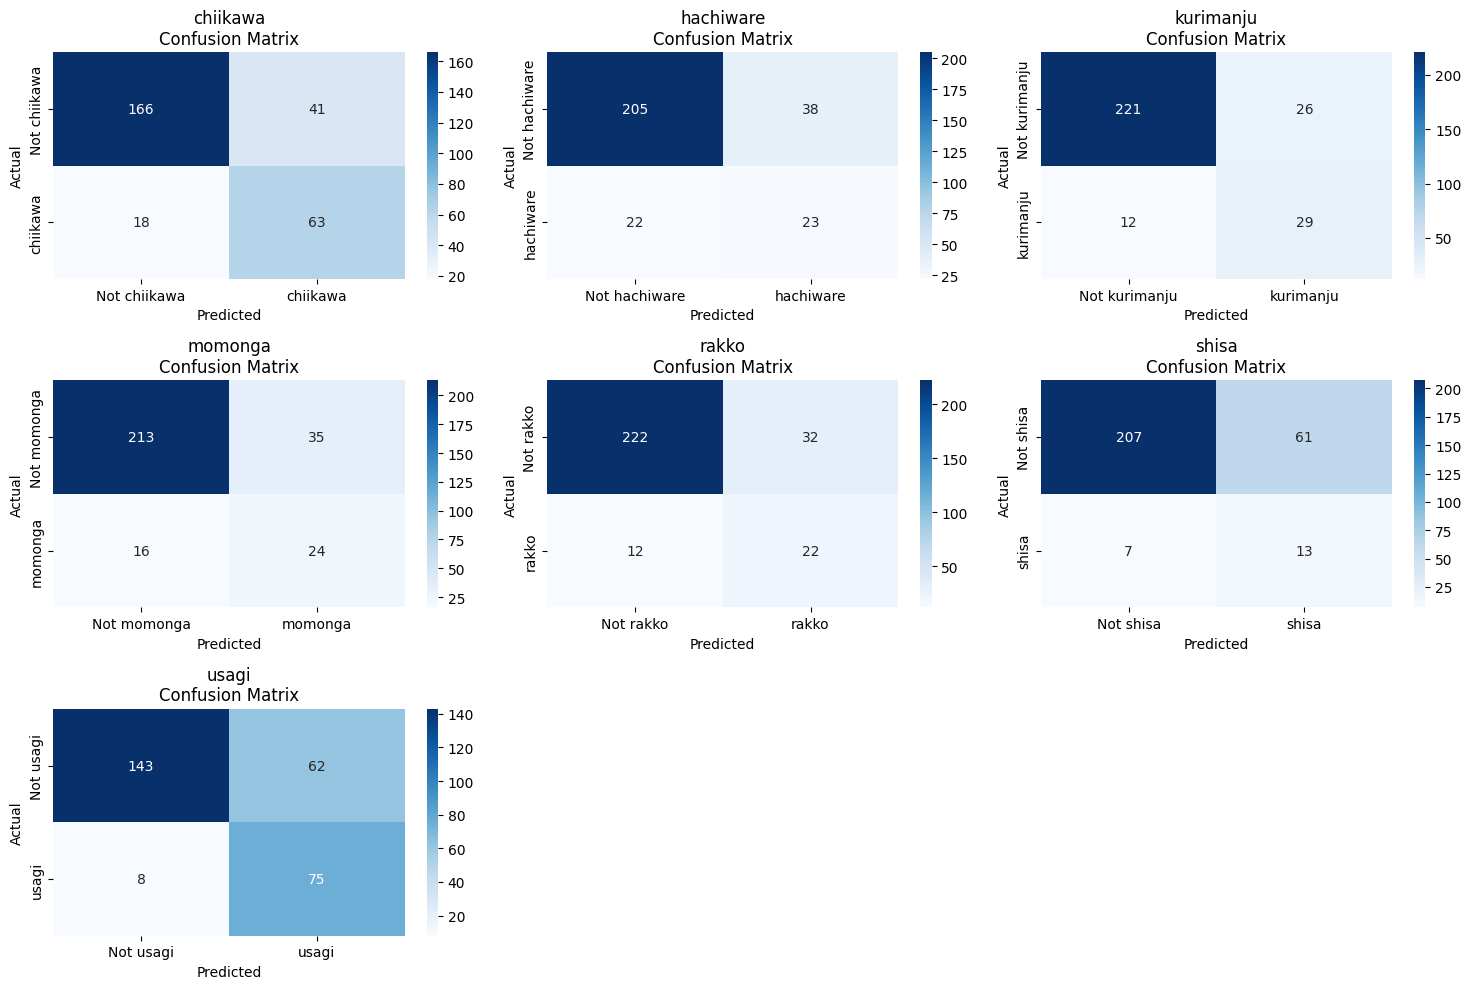


2. 每個類別的詳細指標:
       Class  TP   TN  FP  FN  Precision  Recall  F1-Score  Specificity  \
0   chiikawa  63  166  41  18      0.606   0.778     0.681        0.802   
1  hachiware  23  205  38  22      0.377   0.511     0.434        0.844   
2  kurimanju  29  221  26  12      0.527   0.707     0.604        0.895   
3    momonga  24  213  35  16      0.407   0.600     0.485        0.859   
4      rakko  22  222  32  12      0.407   0.647     0.500        0.874   
5      shisa  13  207  61   7      0.176   0.650     0.277        0.772   
6      usagi  75  143  62   8      0.547   0.904     0.682        0.698   

   Accuracy  
0     0.795  
1     0.792  
2     0.868  
3     0.823  
4     0.847  
5     0.764  
6     0.757  

3. 標籤頻率比較:


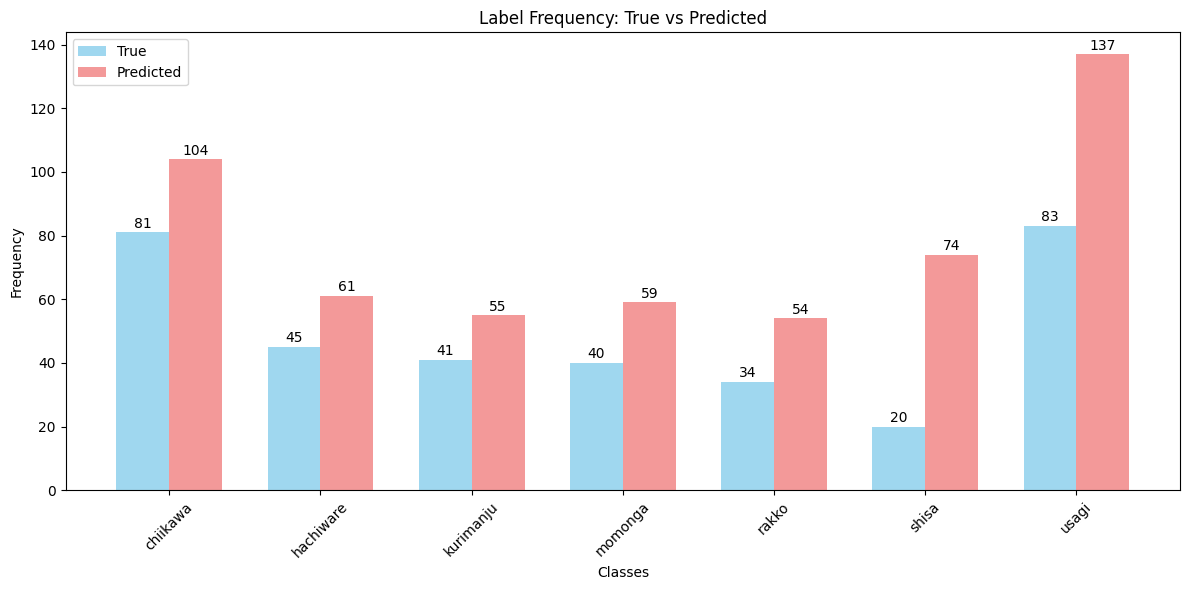


4. 標籤共現矩陣:


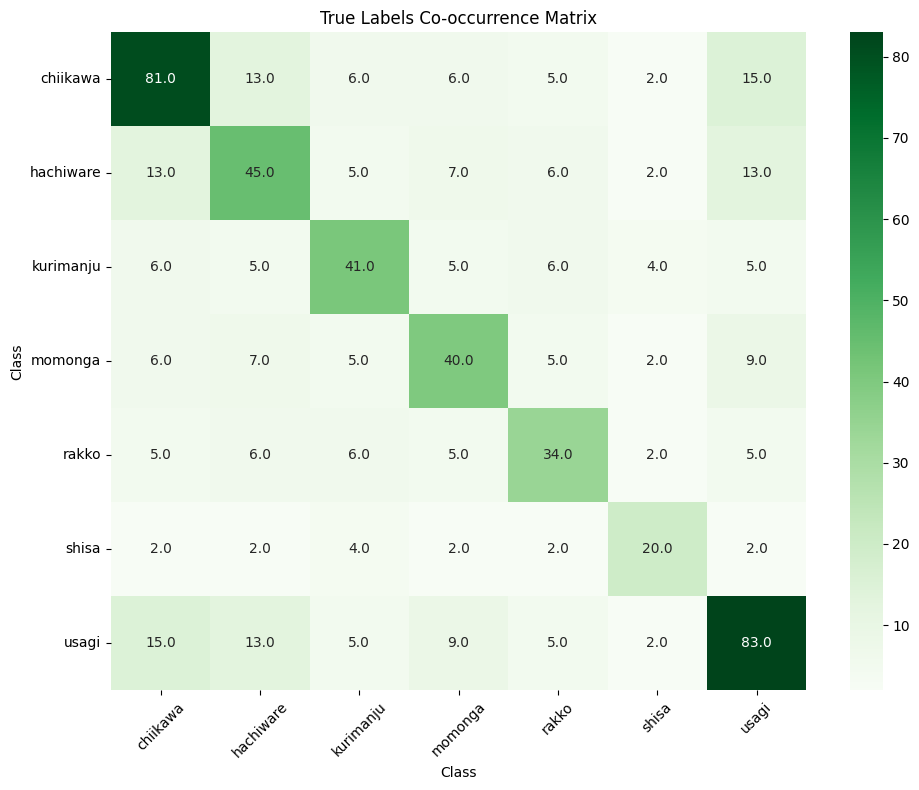

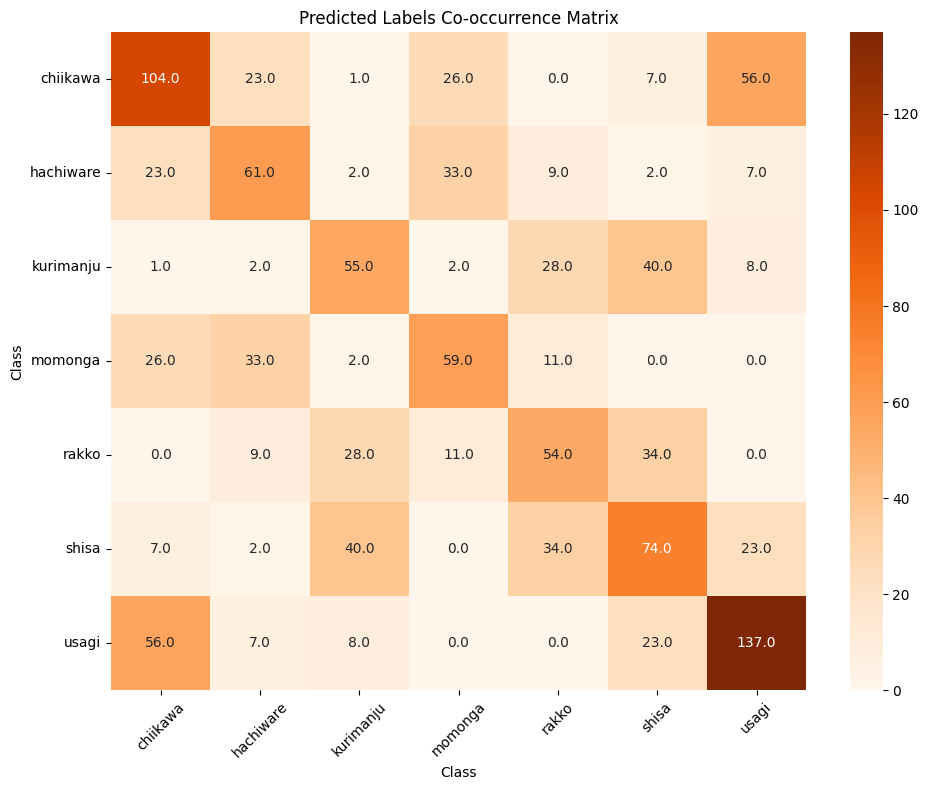


5. 子集준確度分析:


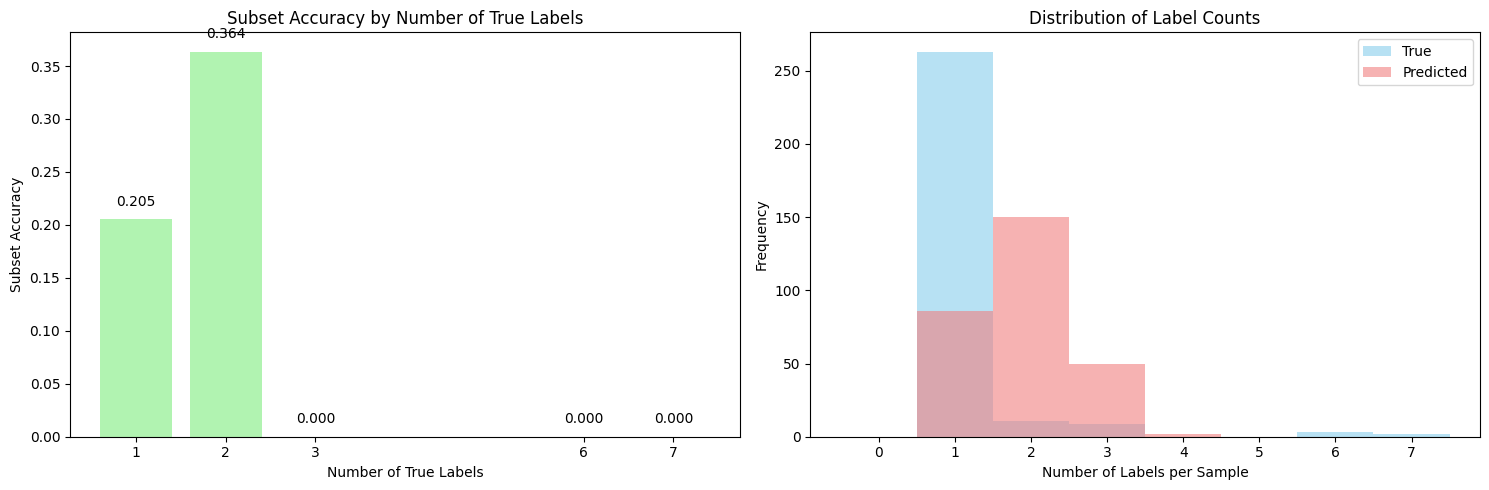

Overall Subset Accuracy: 0.201


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import pandas as pd
class_names = ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']

def plot_multilabel_confusion_matrices(y_true, y_pred, class_names, figsize=(15, 10)):
    """
    為每個類別繪製二元混淆矩陣 (每個類別 vs 其他所有類別)
    """
    # 計算多標籤混淆矩陣
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    n_classes = len(class_names)
    cols = 3
    rows = (n_classes + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if n_classes > 1 else [axes]

    for i, class_name in enumerate(class_names):
        cm = mcm[i]

        # 繪製熱力圖
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Not ' + class_name, class_name],
                   yticklabels=['Not ' + class_name, class_name])
        axes[i].set_title(f'{class_name}\nConfusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # 隱藏多餘的子圖
    for i in range(n_classes, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    return mcm


def plot_label_cooccurrence_matrix(y_true, y_pred, class_names, plot_type='both'):
    """
    繪製標籤共現矩陣 (顯示哪些標籤經常一起出現)
    """
    if plot_type in ['true', 'both']:
        # 真實標籤的共現矩陣
        true_cooc = np.dot(y_true.T, y_true)

        plt.figure(figsize=(10, 8))
        sns.heatmap(true_cooc, annot=True, fmt='.1f', cmap='Greens',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('True Labels Co-occurrence Matrix')
        plt.xlabel('Class')
        plt.ylabel('Class')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    if plot_type in ['pred', 'both']:
        # 預測標籤的共現矩陣
        pred_cooc = np.dot(y_pred.T, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(pred_cooc, annot=True, fmt='.1f', cmap='Oranges',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Predicted Labels Co-occurrence Matrix')
        plt.xlabel('Class')
        plt.ylabel('Class')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()


def plot_label_frequency_comparison(y_true, y_pred, class_names):
    """
    比較真實標籤和預測標籤的頻率分布
    """
    true_freq = y_true.sum(axis=0)
    pred_freq = y_pred.sum(axis=0)

    x = np.arange(len(class_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width/2, true_freq, width, label='True', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, pred_freq, width, label='Predicted', alpha=0.8, color='lightcoral')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Frequency')
    ax.set_title('Label Frequency: True vs Predicted')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()

    # 在柱狀圖上顯示數值
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def compute_multilabel_metrics_per_class(y_true, y_pred, class_names):
    """
    計算每個類別的詳細指標
    """
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    metrics_data = []

    for i, class_name in enumerate(class_names):
        tn, fp, fn, tp = mcm[i].ravel()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        metrics_data.append({
            'Class': class_name,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': specificity,
            'Accuracy': accuracy
        })

    df = pd.DataFrame(metrics_data)
    return df


def plot_subset_accuracy_analysis(y_true, y_pred, class_names):
    """
    分析子集準確度 (exact match) 的詳細情況
    """
    # 計算每個樣本的匹配情況
    exact_matches = np.all(y_true == y_pred, axis=1)
    subset_accuracy = np.mean(exact_matches)

    # 統計不同標籤數量的準確度
    true_label_counts = y_true.sum(axis=1)
    pred_label_counts = y_pred.sum(axis=1)

    # 按真實標籤數量分組的準確度
    unique_counts = np.unique(true_label_counts)
    accuracy_by_count = []

    for count in unique_counts:
        mask = (true_label_counts == count)
        if np.any(mask):
            acc = np.mean(exact_matches[mask])
            accuracy_by_count.append(acc)
        else:
            accuracy_by_count.append(0)

    # 繪製圖表
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 子圖1: 按標籤數量的準確度
    ax1.bar(unique_counts, accuracy_by_count, alpha=0.7, color='lightgreen')
    ax1.set_xlabel('Number of True Labels')
    ax1.set_ylabel('Subset Accuracy')
    ax1.set_title('Subset Accuracy by Number of True Labels')
    ax1.set_xticks(unique_counts)

    # 在柱狀圖上顯示數值
    for i, acc in enumerate(accuracy_by_count):
        ax1.text(unique_counts[i], acc + 0.01, f'{acc:.3f}',
                ha='center', va='bottom')

    # 子圖2: 標籤數量分布比較
    bins = np.arange(0, max(max(true_label_counts), max(pred_label_counts)) + 2) - 0.5
    ax2.hist(true_label_counts, bins=bins, alpha=0.6, label='True', color='skyblue')
    ax2.hist(pred_label_counts, bins=bins, alpha=0.6, label='Predicted', color='lightcoral')
    ax2.set_xlabel('Number of Labels per Sample')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Label Counts')
    ax2.legend()
    ax2.set_xticks(range(int(max(max(true_label_counts), max(pred_label_counts))) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Overall Subset Accuracy: {subset_accuracy:.3f}")
    return subset_accuracy


def comprehensive_multilabel_analysis(y_true, y_pred, class_names):
    """
    完整的多標籤分類分析
    """
    print("=== 多標籤分類完整分析 ===\n")

    # 1. 每個類別的混淆矩陣
    print("1. 每個類別的二元混淆矩陣:")
    mcm = plot_multilabel_confusion_matrices(y_true, y_pred, class_names)

    # 2. 每個類別的詳細指標
    print("\n2. 每個類別的詳細指標:")
    metrics_df = compute_multilabel_metrics_per_class(y_true, y_pred, class_names)
    print(metrics_df.round(3))

    # 3. 標籤頻率比較
    print("\n3. 標籤頻率比較:")
    plot_label_frequency_comparison(y_true, y_pred, class_names)

    # 4. 標籤共現分析
    print("\n4. 標籤共現矩陣:")
    plot_label_cooccurrence_matrix(y_true, y_pred, class_names)

    # 5. 子集準確度分析
    print("\n5. 子集준確度分析:")
    subset_acc = plot_subset_accuracy_analysis(y_true, y_pred, class_names)

    return {
        'confusion_matrices': mcm,
        'metrics_per_class': metrics_df,
        'subset_accuracy': subset_acc
    }


# 修改原評估函數以包含多標籤分析
def evaluate_model_with_multilabel_analysis(model, test_loader, class_names, device='cuda',
                                          threshold=0.5, show_analysis=True):
    """
    評估模型並進行完整的多標籤分析
    """

    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels, *_ in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.sigmoid(outputs)
            predictions = (probs > threshold).float()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    if show_analysis:
        # 進行完整的多標籤分析
        analysis_results = comprehensive_multilabel_analysis(
            all_labels, all_predictions, class_names
        )
        return all_predictions, all_labels, all_probs, analysis_results
    else:
        return all_predictions, all_labels, all_probs


def load_predictions_from_csv(csv_file=None, pred_csv=None, true_csv=None, class_names=None):
    """
    從 CSV 檔案讀取預測結果和真實標籤

    方法1 - 單一 CSV 檔案格式:
    image_name,predicted_labels,true_labels
    case_001,0 2,0 2
    case_002,1 4 5,1 4
    case_003,,0 1 3

    方法2 - 分開的兩個 CSV 檔案:
    pred.csv: image_name,labels
    true.csv: image_name,labels
    """

    if csv_file is not None:
        # 方法1: 單一檔案包含兩者
        df = pd.read_csv(csv_file)
        n_samples = len(df)
        n_classes = len(class_names)

        y_pred = np.zeros((n_samples, n_classes))
        y_true = np.zeros((n_samples, n_classes))

        for i, row in df.iterrows():
            # 處理預測標籤
            if pd.notna(row['predicted_labels']) and str(row['predicted_labels']).strip():
                pred_indices = [int(x) for x in str(row['predicted_labels']).split()]
                y_pred[i, pred_indices] = 1

            # 處理真實標籤
            if pd.notna(row['true_labels']) and str(row['true_labels']).strip():
                true_indices = [int(x) for x in str(row['true_labels']).split()]
                y_true[i, true_indices] = 1

        return y_true, y_pred

    elif pred_csv is not None and true_csv is not None:
        # 方法2: 分開的兩個檔案
        pred_df = pd.read_csv(pred_csv)
        true_df = pd.read_csv(true_csv)

        # 確保兩個檔案有相同的 image_name 順序
        pred_df = pred_df.sort_values('image_name').reset_index(drop=True)
        true_df = true_df.sort_values('image_name').reset_index(drop=True)

        # 檢查 image_name 是否匹配
        if not pred_df['image_name'].equals(true_df['image_name']):
            print("警告: 預測檔案和真實標籤檔案的 image_name 不完全匹配!")
            # 取交集
            common_ids = set(pred_df['image_name']) & set(true_df['image_name'])
            pred_df = pred_df[pred_df['image_name'].isin(common_ids)].sort_values('image_name').reset_index(drop=True)
            true_df = true_df[true_df['image_name'].isin(common_ids)].sort_values('image_name').reset_index(drop=True)
            print(f"使用共同的 {len(common_ids)} 個案例")

        n_samples = len(pred_df)
        n_classes = len(class_names)

        y_pred = np.zeros((n_samples, n_classes))
        y_true = np.zeros((n_samples, n_classes))

        # 處理預測標籤
        for i, row in pred_df.iterrows():
            if pd.notna(row['labels']) and str(row['labels']).strip():
                pred_indices = [int(x) for x in str(row['labels']).split()]
                y_pred[i, pred_indices] = 1

        # 處理真實標籤
        for i, row in true_df.iterrows():
            if pd.notna(row['labels']) and str(row['labels']).strip():
                true_indices = [int(x) for x in str(row['labels']).split()]
                y_true[i, true_indices] = 1

        return y_true, y_pred

    else:
        raise ValueError("請提供 csv_file 或 (pred_csv 和 true_csv)")


def load_predictions_from_separate_files(pred_csv, true_csv, class_names):
    """
    從兩個分開的 CSV 檔案讀取預測結果和真實標籤

    兩個檔案格式都是:
    image_name,labels
    case_001,0 2
    case_002,1 4 5
    case_003,
    """
    return load_predictions_from_csv(pred_csv=pred_csv, true_csv=true_csv, class_names=class_names)

def analyze_predictions_from_csv(csv_file=None, pred_csv=None, true_csv=None, class_names=None):
    """
    從 CSV 檔案進行多標籤分析

    使用方法:
    1. 單一檔案: analyze_predictions_from_csv(csv_file='combined.csv', class_names=class_names)
    2. 分開檔案: analyze_predictions_from_csv(pred_csv='pred.csv', true_csv='true.csv', class_names=class_names)
    """
    if csv_file is not None:
        print(f"從單一 CSV 檔案讀取預測結果: {csv_file}")
        y_true, y_pred = load_predictions_from_csv(csv_file=csv_file, class_names=class_names)
    elif pred_csv is not None and true_csv is not None:
        print(f"從分開的 CSV 檔案讀取預測結果:")
        print(f"  預測檔案: {pred_csv}")
        print(f"  真實標籤檔案: {true_csv}")
        y_true, y_pred = load_predictions_from_csv(pred_csv=pred_csv, true_csv=true_csv, class_names=class_names)
    else:
        raise ValueError("請提供 csv_file 或 (pred_csv 和 true_csv)")

    print(f"讀取了 {len(y_true)} 個樣本，{len(class_names)} 個類別")

    # 進行完整分析
    return comprehensive_multilabel_analysis(y_true, y_pred, class_names)

# 使用範例
# """
# class_names = model = SimpleCNN(num_classes=num_classes).to(device)
# model = SimpleCNN(num_classes=num_classes).to(device)
# model.load_state_dict(torch.load('best_model.pth', weights_only=False))
# # # 方法1: 從模型直接評估
# predictions, labels, probs, analysis = evaluate_model_with_multilabel_analysis(
#     model=model,
#     test_loader=test_loader,
#     class_names=class_names,
#     device='cuda',
#     threshold=0.5,
#     show_analysis=True
# )

# # 方法2: 從單一 CSV 檔案分析（包含預測和真實標籤）
# analysis_results = analyze_predictions_from_csv(
#     csv_file='predictions.csv',
#     class_names=class_names
# )

# # 方法3: 從兩個分開的 CSV 檔案分析
analysis_results = analyze_predictions_from_csv(
    pred_csv='predicted.csv',
    true_csv='ground_truth.csv',
    class_names=class_names
)

# # 方法4: 手動載入後分析
# # 單一檔案
# y_true, y_pred = load_predictions_from_csv(csv_file='combined.csv', class_names=class_names)

# # 或分開的檔案
# y_true, y_pred = load_predictions_from_csv(pred_csv='pred.csv', true_csv='true.csv', class_names=class_names)

# # 然後分析
# analysis_results = comprehensive_multilabel_analysis(y_true, y_pred, class_names)
# """



# # 如果是單一檔案
# analysis = analyze_predictions_from_csv(
#     csv_file='combined_results.csv',
#     class_names=class_names
# )

# # 如果是兩個分開的檔案
# analysis = analyze_predictions_from_csv(
#     pred_csv='test_predictions.csv',
#     true_csv='ground_truth.csv',
#     class_names=class_names
# )




# evaluation

✅ 已儲存 ground_truth.csv 和 predicted.csv


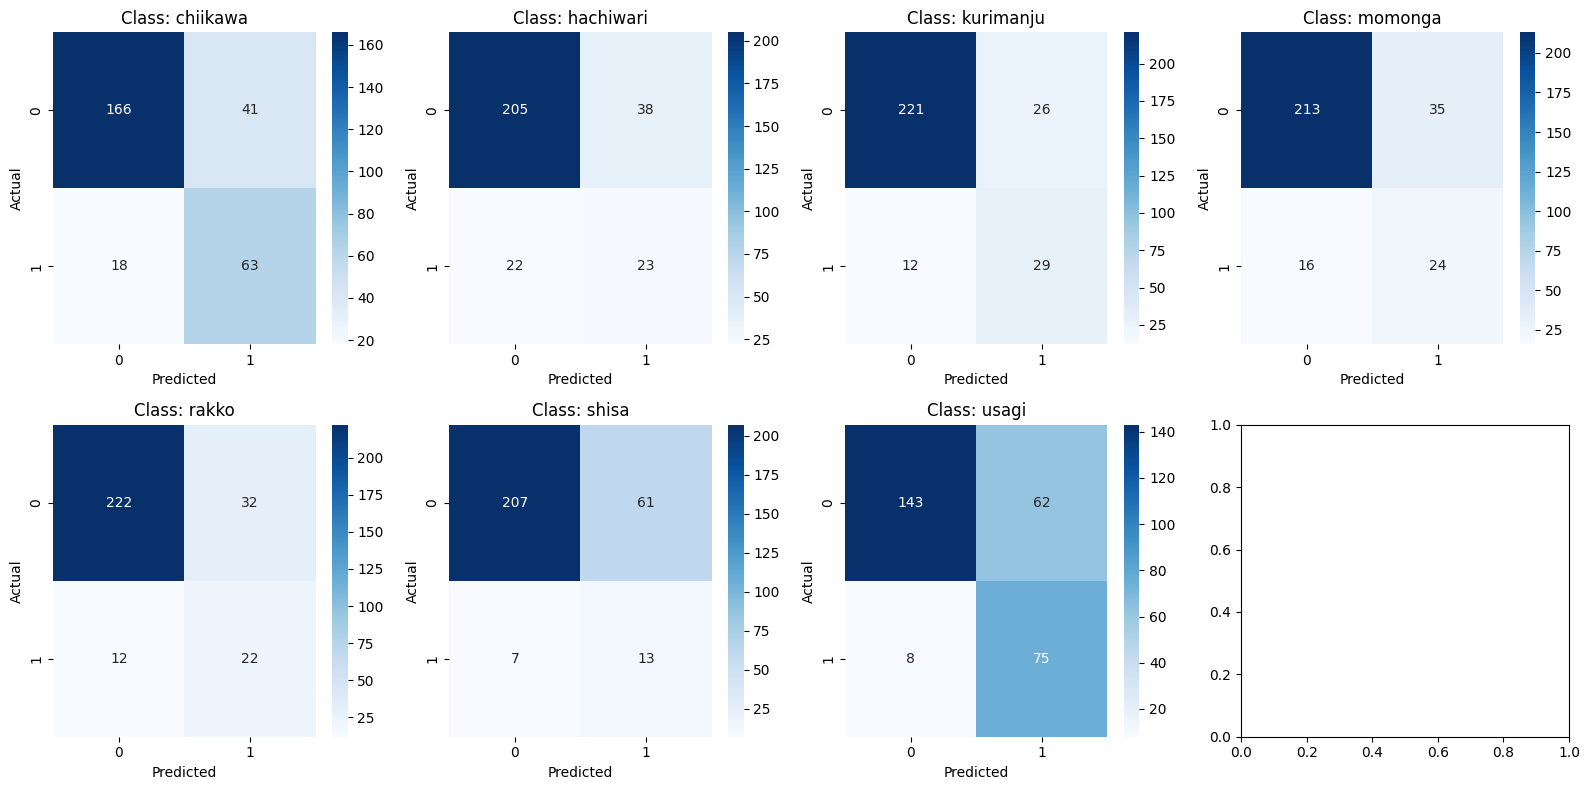

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
all_labels, all_preds = evaluate_multilabel(model, test_loader)
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    繪製 multi-label confusion matrix（每個類別各一個）
    """
    cm = multilabel_confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(nrows=2, ncols=(len(class_names) + 1) // 2, figsize=(16, 8))
    axes = axes.flatten()

    for i, (label, matrix) in enumerate(zip(class_names, cm)):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Class: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['0', '1'])
        axes[i].set_yticklabels(['0', '1'])

    plt.tight_layout()
    plt.show()

plot_multilabel_confusion_matrix(all_labels, all_preds, [
    "chiikawa", "hachiwari", "kurimanju", "momonga", "rakko", "shisa", "usagi"
])
